In [2]:
import os
import argparse
import pandas as pd
import numpy as np
from scipy import interpolate
from sklearn.model_selection import KFold
from collections import Counter
import matplotlib.pyplot as plt
import random
import pickle
import json
import time

'''
This script is to fit the spline model for the fragment length from the collected datasets.
'''
parser = json.load(open("params.json", "r"))
parent_dir = parser["parent_dir"]
outdir = parser["outdir"]
PE_sheet_path = parser["PE_sheet"]
random_seed = parser["random_seed"]

# parser = argparse.ArgumentParser(
#     description="Count and summarize non-zero length reads.")
# parser.add_argument("parent_dir", type=str,
#                     help="the parent dir having all fragment length output")
# parser.add_argument("PE_sheet", type=str,
#                     help="path to the spreadsheet with GSR,SRR list")
# parser.add_argument("random_seed", type=int, default=10,
#                     help="random seed for random sampling")
# parser.add_argument("outdir", type=str,
#                     help="where to save the output")

# args = parser.parse_args()
# args = parser.parse_args(["/fs/nexus-projects/sc_frag_len/nextflow/workflow_output",
#                           "/fs/nexus-projects/sc_frag_len/nextflow/input_files/sample_url_sheet.csv",
#                           "10",
#                           "/fs/nexus-projects/sc_frag_len/nextflow/fit_model/Jan24_out"])



# parent_dir = args.parent_dir
# outdir = args.outdir

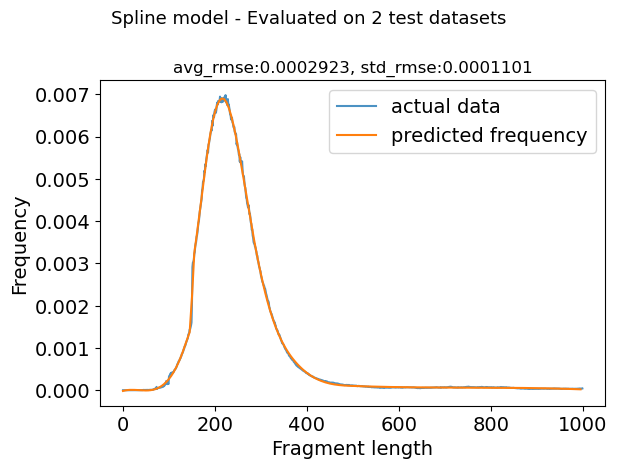

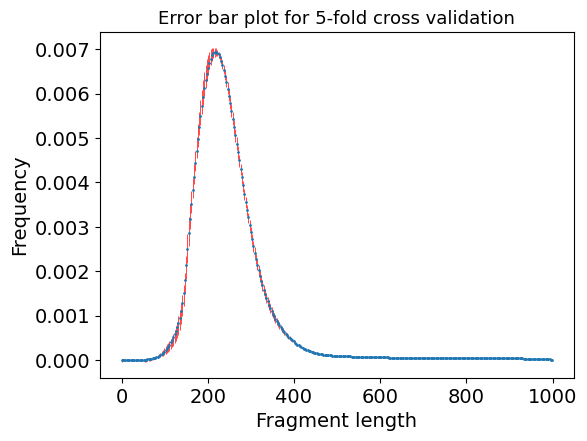

In [3]:

# 1----- Get the PE datasets spreadsheet
PE_sheet = pd.read_csv(PE_sheet_path)
os.makedirs(os.path.join(outdir, "out_figures"), exist_ok=True)

# 2----- loop through GSE(s), combine tlen from all SRRs in this GSE
# check if all datasets have been processed
GSE_lst = PE_sheet['GSE'].unique()
error_occur = False
missing_files = []
for i in range(len(GSE_lst)):
    GSE = GSE_lst[i]
    SRR_lst = PE_sheet.loc[PE_sheet['GSE'] == GSE, 'SRR']

    for SRR in SRR_lst:
        new_tlen_path = os.path.join(
            parent_dir, f"process_data/frag_len_dist/{GSE}/{SRR}/{SRR}_new_tlens.txt")

        if os.path.exists(new_tlen_path):
            check_file = os.path.getsize(new_tlen_path)
            if (check_file == 0):
                missing_files.append(f"{GSE}-{SRR}")
                error_occur = True
        else:
            missing_files.append(f"{GSE}-{SRR}")
            error_occur = True

if error_occur == True:
    raise ValueError(f"Please re-run the previous step, \
                     the output of following dataset(s) is either missing or empty: {missing_files}")
# We integrate all the tlen file if all datasets have been processed successfully
else:  # when error_occur == False
    df_tlen_count = pd.DataFrame()
    GSE_lst = PE_sheet['GSE'].unique()
    for i in range(len(GSE_lst)):
        GSE = GSE_lst[i]
        SRR_lst = PE_sheet.loc[PE_sheet['GSE'] == GSE, 'SRR']
        valid_tlen_per_GSE = []
        for SRR in SRR_lst:
            new_tlen_path = os.path.join(
                parent_dir, f"process_data/frag_len_dist/{GSE}/{SRR}/{SRR}_new_tlens.txt")
            new_tlen = pd.read_csv(new_tlen_path, sep='\t')
            new_tlen = new_tlen.iloc[:, 0].tolist()
            # we only used the fragment length < 1000 for the distribution model
            valid_tlen = [x for x in new_tlen if x < 1000]
            valid_tlen_per_GSE += valid_tlen

        # calculate the frequency of each fragment length for each GSE
        count_tlen = Counter(np.array(valid_tlen_per_GSE))
        freq_lst = []
        for key in np.arange(1000):
            if key in list(count_tlen.keys()):
                tlen_count = count_tlen[key]
            else:
                tlen_count = 0
            freq_lst.append(tlen_count/len(valid_tlen_per_GSE))

        df_new_col = pd.DataFrame({GSE: freq_lst})
        df_tlen_count = pd.concat(
            [df_tlen_count, df_new_col], axis=1)

    all_GSE_list = df_tlen_count.columns.values.tolist()

    # randomly select 8 datasets for training
    random.seed(random_seed)
    train_list = random.sample(all_GSE_list, 8)
    df_tlen_count_train = df_tlen_count[train_list]
    test_list = [d for d in all_GSE_list if d not in train_list]

    # calculate the mean frequency of each fragment length for the 8 train datasets
    mean_freq = df_tlen_count_train.mean(axis=1)
    # normalize
    norm_mean_freq = mean_freq/sum(mean_freq)

    x_data = np.arange(1000)
    y_data = norm_mean_freq

    # fit the model
    spline = interpolate.splrep(x_data, y_data, k=3, s=1/1000000)

    # save the spline model using pickle
    model_pkl_path = os.path.join(outdir, 'spline_model.pkl')
    with open(model_pkl_path, 'wb') as file_model:
        pickle.dump(spline, file_model)
    # save the dataframe of tlen count perGSE using pickle
    df_tlen_path = os.path.join(outdir, "df_tlen.pkl")
    with open(df_tlen_path, 'wb') as file_df:
        pickle.dump(df_tlen_count, file_df)

    # calculate RMSE and plot
    plt.figure(1)
    plt.rcParams.update({'font.size': 14})
    # plot actual data
    plt.plot(x_data, y_data, '-', label=f"actual data", alpha=0.8)

    x_test = np.arange(0, 1000, 5)
    rmse = []
    for GSE in test_list:
        y_actual = []
        for x in x_test:
            y_actual.append(df_tlen_count.loc[:, GSE].tolist()[x])
        y_predict = interpolate.splev(x_test, spline)
        # Calculate RMSE
        rmse.append(round(np.sqrt(np.mean((y_actual - y_predict) ** 2)), 7))

    plt.plot(x_test, interpolate.BSpline(
        *spline)(x_test), '-', label="predicted frequency")

    plt.xlabel('Fragment length')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.suptitle('Spline model - Evaluated on 2 test datasets',
                 horizontalalignment='center', fontsize=13)
    plt.title(f"avg_rmse:{round(np.mean(rmse),7)}, std_rmse:{round(np.std(rmse),7)}",
              horizontalalignment='center', fontsize=12)
    plt.tight_layout()
    
    plt.savefig(os.path.join(outdir, "out_figures",
                "fit_spline_rmse.jpg"), dpi=500)
    plt.show()
    # plt.clf()
    # plt.close()

    test_rmse = {
        test_list[0]: round(rmse[0], 7),
        test_list[1]: round(rmse[1], 7)
    }
    with open(os.path.join(outdir, 'test_rmse.json'), 'w') as file:
        json.dump(test_rmse, file)

    # split datasets to 5 folds
    random.seed(37)
    random.shuffle(all_GSE_list)
    kf = KFold(n_splits=5)
    x_test = np.arange(0, 1000, 3)
    predicted_y_all_folds = pd.DataFrame()
    i = 0
    for train_index, test_index in kf.split(all_GSE_list):
        train_list = [all_GSE_list[i] for i in train_index]
        # test_list = [all_GSE_list[i] for i in test_index]
        # preprocess train data
        df_tlen_train = df_tlen_count[train_list]
        mean_freq = df_tlen_train.mean(axis=1)
        # normalize
        norm_mean_freq = mean_freq/sum(mean_freq)
        x_data = np.arange(0, 1000, 3)
        y_data = [norm_mean_freq[i] for i in x_data]
        # fit model and get predicted y
        spline_cv = interpolate.splrep(x_data, y_data, k=3, s=1/1000000)
        y_predict_cv = interpolate.splev(x_test, spline_cv)

        predicted_y_all_folds[f"fold_{i}"] = y_predict_cv
        i += 1

    # mean of errors from CV
    predicted_y_all_folds['mean'] = predicted_y_all_folds.mean(axis=1)
    mean_predicted_y = predicted_y_all_folds['mean'].tolist()
    err_all_folds = predicted_y_all_folds.sub(
        predicted_y_all_folds['mean'], axis=0)
    err_all_folds_sub = err_all_folds.iloc[:, :5]

    err_all_folds_sub['min'] = err_all_folds_sub.min(axis=1)
    err_all_folds_sub['max'] = err_all_folds_sub.max(axis=1)
    y_lower = err_all_folds_sub['min'].tolist()
    y_lower = [abs(x) if x < 0 else 0 for x in y_lower]
    y_upper = err_all_folds_sub['max'].tolist()
    y_upper = [x if x > 0 else 0 for x in y_upper]

    errors = [y_lower, y_upper]

    plt.figure(2)
    plt.rcParams.update({'font.size': 14})
    plt.errorbar(x_test, mean_predicted_y, yerr=errors, fmt='o',
                 ecolor='red', elinewidth=0.5, ms=1)
    plt.subplots_adjust(left=0.16, bottom=0.16)
    plt.xlabel('Fragment length')
    plt.ylabel('Frequency')
    plt.title('Error bar plot for 5-fold cross validation',fontsize=13)
    plt.savefig(os.path.join(outdir, "out_figures",
                "fit_spline_errbar.jpg"), dpi=500)
    plt.show()
    plt.close()